In [43]:
import numpy as np
import pandas as pd
from scipy.stats import trim_mean, kurtosis, skew
from scipy.stats import skew, boxcox, yeojohnson
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotx
import lovelyplots
import warnings
# plt.style.use(['gruvbox','use_mathtext','colors5'])
plt.style.use(matplotx.styles.nord)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 16
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica']


## Data Exploration and Preprocessing

Let's start by exploring our dataset to understand its structure and the type of data we have. We'll perform the following steps:

1. **Loading the Data**: Import the dataset and take a quick look at the first few rows.
2. **Handling Missing Values**: Identify and handle any missing data.
3. **Feature Engineering**: Create new features or modify existing ones to improve our models.
4. **Transforming Skewed Features**: Apply transformations to features with skewed distributions to make them more normal.
5. **Encoding Categorical Variables**: Convert categorical variables into numerical formats.
6. **Scaling**: Standardize or normalize features to bring them onto a common scale.
7. **Train-Test Split**: Divide the dataset into training and testing sets to evaluate model performance.

By the end of this section, we'll have a clean and well-prepared dataset ready for modeling.


### Pre-Screen

In [45]:
data = pd.read_csv('credit_risk_dataset.csv')

In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_amnt                   32581 non-null  int64  
 6   loan_int_rate               29465 non-null  float64
 7   loan_status                 32581 non-null  int64  
 8   loan_percent_income         32581 non-null  float64
 9   cb_person_default_on_file   32581 non-null  object 
 10  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 2.7+ MB


In [47]:
data.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [48]:
data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,35000,14.27,1,0.55,Y,4


In [49]:
print(f'The Shape of Dataset:\nNumber of rows: {data.shape[0]}\nNumber of columns: {data.shape[1]}')

The Shape of Dataset:
Number of rows: 32581
Number of columns: 11


### Statistic Summary

In [50]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,32581.0,27.734600,6.348078,20.00,23.00,26.00,30.00,144.00
person_income,32581.0,66074.848470,61983.119168,4000.00,38500.00,55000.00,79200.00,6000000.00
person_emp_length,31686.0,4.789686,4.142630,0.00,2.00,4.00,7.00,123.00
loan_amnt,32581.0,9589.371106,6322.086646,500.00,5000.00,8000.00,12200.00,35000.00
loan_int_rate,29465.0,11.011695,3.240459,5.42,7.90,10.99,13.47,23.22
loan_status,32581.0,0.218164,0.413006,0.00,0.00,0.00,0.00,1.00
loan_percent_income,32581.0,0.170203,0.106782,0.00,0.09,0.15,0.23,0.83
cb_person_cred_hist_length,32581.0,5.804211,4.055001,2.00,3.00,4.00,8.00,30.00


##### 📝 Insights from the Summary Statistics

**Interest Rate (`loan_int_rate`)**:
- **Mean**: 11.01%
- **Range**: 5.42% to 23.22%
- **Insights**: Interest rates vary a lot, suggesting different risk levels. Most loans have interest rates between 8.49% and 13.11% (25th to 75th percentile).

**Employment Length (`person_emp_length`)**:
- **Mean**: 4.78 years
- **Range**: 0 to 123 years
- **Insights**: Employment length varies widely, but values like 123 years are unrealistic and should be treated as outliers.

**Loan Amount (`loan_amnt`)**:
- **Mean**: $9,589.37
- **Range**: $500 to $35,000
- **Insights**: Loan amounts also vary, reflecting different financial needs.

**Person Age (`person_age`)**:
- **Mean**: 27.73 years
- **Range**: 20 to 144 years
- **Insights**: The age range suggests most borrowers are young adults, but values like 144 years are unrealistic and need review.

**Person Income (`person_income`)**:
- **Mean**: $66,074.85
- **Range**: $4,000 to $6,000,000
- **Insights**: Incomes vary greatly, indicating a mix of low and high earners.

**Debt-to-Income Ratio (`loan_percent_income`)**:
- **Mean**: 0.17
- **Range**: 0 to 0.83
- **Insights**: Indicates the fraction of income going to loan repayments. Most values are low, showing manageable debt levels.

**Credit History Length (`cb_person_cred_hist_length`)**:
- **Mean**: 5.80 years
- **Range**: 2 to 30 years
- **Insights**: Most borrowers have a few years of credit history, which can help in assessing creditworthiness.

The dataset shows a wide range of borrower profiles. Here are the key points:
- **Interest Rates**: Vary widely, indicating different risk levels.
- **Employment Length**: Some unrealistic values need to be treated as outliers.
- **Loan Amounts and Incomes**: Highly variable, reflecting diverse financial situations.
- **Debt Levels**: Generally low, suggesting manageable repayments.
- **Credit History**: Most borrowers have moderate credit history lengths.


In [51]:
data.describe(include='O')

,person_home_ownership,loan_intent,cb_person_default_on_file
count,32581,32581,32581
unique,4,6,2
top,RENT,EDUCATION,N
freq,16446,6453,26836


##### 📝 Insights from the Categorical Data Summary

**Home Ownership (`person_home_ownership`)**:
- **Unique Values**: 4
- **Most Common**: RENT (16,446 occurrences)
- **Insights**: Most borrowers are renting their homes, indicating a potential lack of home equity which could impact creditworthiness.

**Loan Intent (`loan_intent`)**:
- **Unique Values**: 6
- **Most Common**: EDUCATION (6,453 occurrences)
- **Insights**: Education is the most common reason for taking loans, suggesting a significant portion of borrowers are using loans to fund their studies.

**Default on File (`cb_person_default_on_file`)**:
- **Unique Values**: 2
- **Most Common**: N (26,836 occurrences)
- **Insights**: Most borrowers do not have a default on their credit file, indicating a generally creditworthy population.


The categorical data shows the following patterns:
- **Home Ownership**: Predominantly renters, which may affect their ability to offer collateral.
- **Loan Intent**: Education loans are the most frequent, highlighting a focus on borrowing for educational purposes.
- **Default on File**: Majority have no default history, suggesting lower risk.


In [52]:
data.nunique()

person_age                      58
person_income                 4295
person_home_ownership            4
person_emp_length               36
loan_intent                      6
loan_amnt                      753
loan_int_rate                  348
loan_status                      2
loan_percent_income             77
cb_person_default_on_file        2
cb_person_cred_hist_length      29
dtype: int64

### **Let's EDA !**

In [53]:
num_cols = data.select_dtypes(include=['number'])

mean_vs_trimmed_mean = pd.DataFrame({
    'mean': num_cols.mean(),
    'trimmed_mean': num_cols.apply(lambda x: trim_mean(x, proportiontocut=0.1))
})

kurtosis_skewness = pd.DataFrame({
    'kurtosis': num_cols.apply(kurtosis),
    'skewness': num_cols.apply(skew)
})

print("Mean vs Trimmed Mean:")
print(mean_vs_trimmed_mean.round(2))
print('='*50)
print("\nKurtosis and Skewness:")
print(kurtosis_skewness.round(2))

Mean vs Trimmed Mean:
                                mean  trimmed_mean
person_age                     27.73         26.72
person_income               66074.85      58914.17
person_emp_length               4.79          4.51
loan_amnt                    9589.37       8786.33
loan_int_rate                  11.01         11.57
loan_status                     0.22          0.15
loan_percent_income             0.17          0.16
cb_person_cred_hist_length      5.80          5.13

Kurtosis and Skewness:
                            kurtosis  skewness
person_age                     18.56      2.58
person_income                2692.86     32.86
person_emp_length                NaN       NaN
loan_amnt                       1.42      1.19
loan_int_rate                    NaN       NaN
loan_status                    -0.14      1.36
loan_percent_income             1.22      1.06
cb_person_cred_hist_length      3.72      1.66


**Comparison of Mean and Trimmed Mean**:
- **Purpose**: Helps find outliers in the data.
- **Insight**: If the mean and trimmed mean are very different, there are likely outliers.

**Kurtosis and Skewness**:
- **Purpose**: Understand the shape of the data distribution.
- **Insight**: High kurtosis and skewness indicate outliers and skewed distributions.

**Key Observations**:
- **Outliers**: Features like `loan_amnt` and `loan_int_rate` have outliers affecting their distribution.
- **Distribution Shape**: Some features are not normally distributed and are skewed, meaning they have more extreme values on one side.

In [54]:
cat_cols = data.select_dtypes(include=['object']).columns
for col in cat_cols:
    print(f"Percentage of unique values in column '{col}':")
    value_counts = data[col].value_counts(normalize=True).mul(100).round(2).astype(str) + '%'
    print(value_counts)
    print("=" * 50)
    print()

Percentage of unique values in column 'person_home_ownership':
person_home_ownership
RENT        50.48%
MORTGAGE    41.26%
OWN          7.93%
OTHER        0.33%
Name: proportion, dtype: object

Percentage of unique values in column 'loan_intent':
loan_intent
EDUCATION            19.81%
MEDICAL              18.63%
VENTURE              17.55%
PERSONAL             16.95%
DEBTCONSOLIDATION     16.0%
HOMEIMPROVEMENT      11.06%
Name: proportion, dtype: object

Percentage of unique values in column 'cb_person_default_on_file':
cb_person_default_on_file
N    82.37%
Y    17.63%
Name: proportion, dtype: object




---

**Insights from Categorical Data:**

1. **Home Ownership:** 
   - Most people rent their homes (50.48%).
   - Many have a mortgage (41.26%).
   - Only a few own their homes outright (7.93%).
   - Very few have other types of home ownership (0.33%).

2. **Loan Purpose:**
   - Most loans are for education (19.81%) and medical expenses (18.63%).
   - Some are for new business ventures (17.55%) and personal use (16.95%).
   - Others are for debt consolidation (16.0%) and home improvement (11.06%).

3. **Credit History:**
   - A large majority have no defaults on file (82.37%).
   - A smaller group has defaults on file (17.63%).

---

#### Better to Visualize It !

Box Plot of Numberical

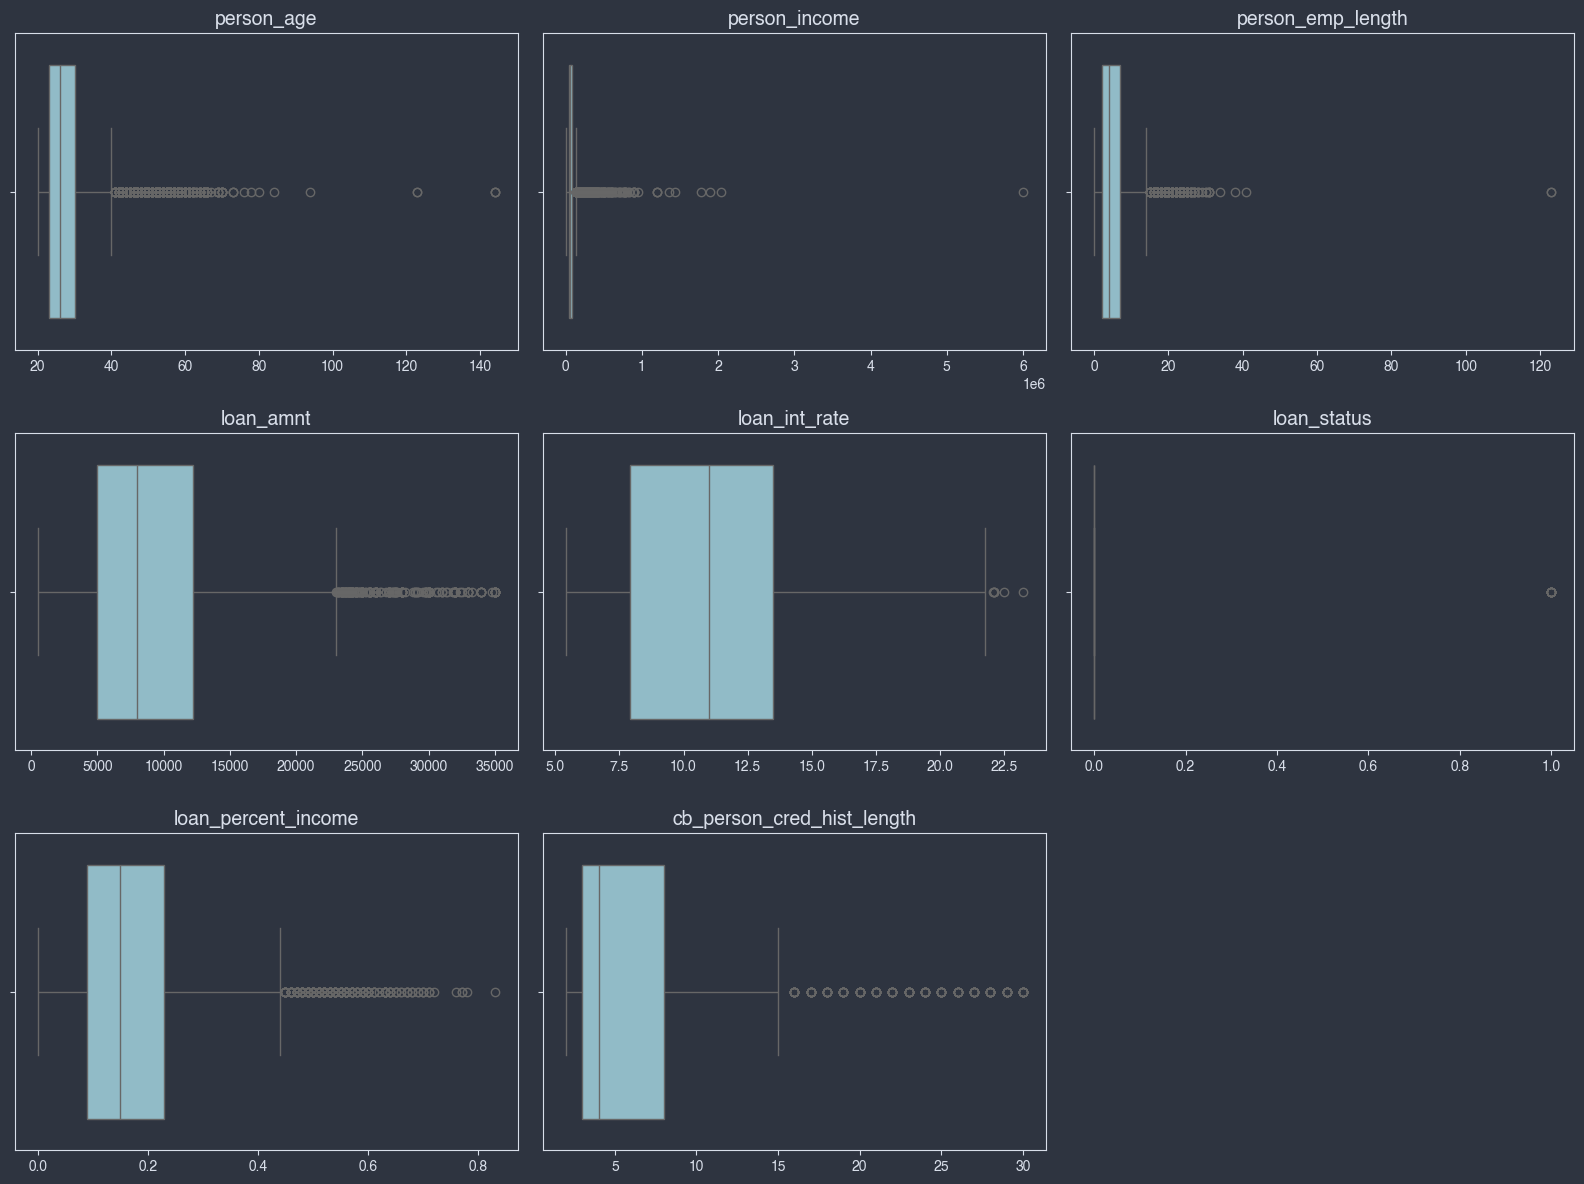

In [55]:
plt.figure(figsize=(16, 12))

for i, column in enumerate(num_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(data=data, x=column)
    plt.title(column, fontsize=14)
    plt.xlabel('')

plt.tight_layout()
plt.show()

Distribution of each Catagory

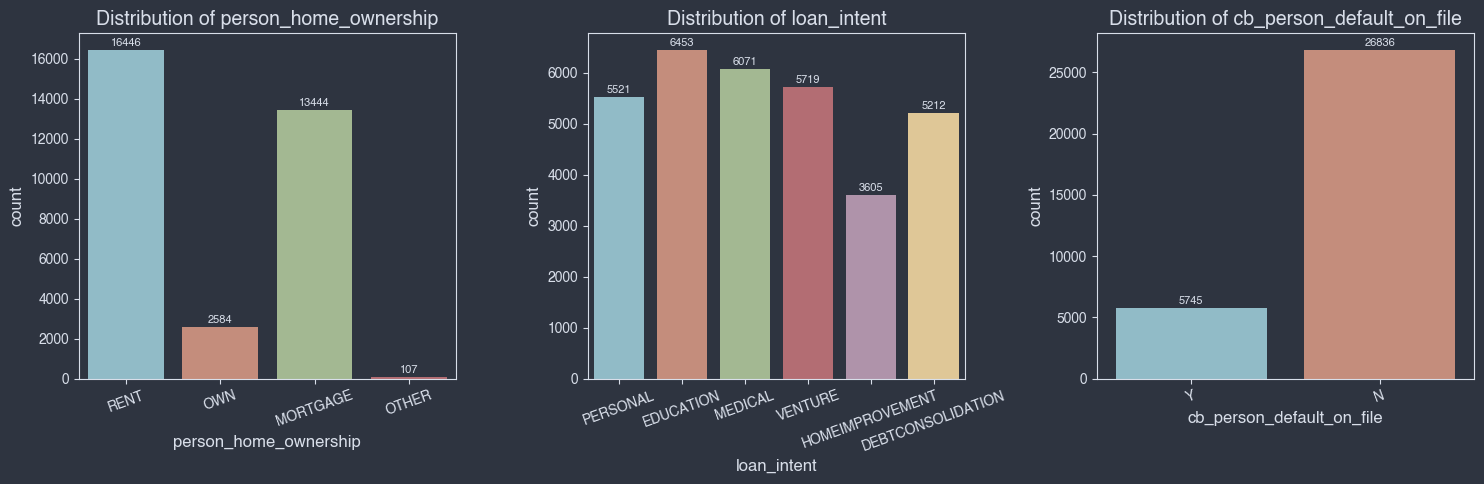

In [56]:
warnings.filterwarnings("ignore")
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, col in zip(axes, cat_cols):
    sns.countplot(x=col, data=data, ax=ax, palette=sns.color_palette())
    ax.set_title(f'Distribution of {col}')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=20,fontsize=10)

    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=8, xytext=(0, 5),
                    textcoords='offset points')

plt.tight_layout()
plt.show()

Distribution of Numberical

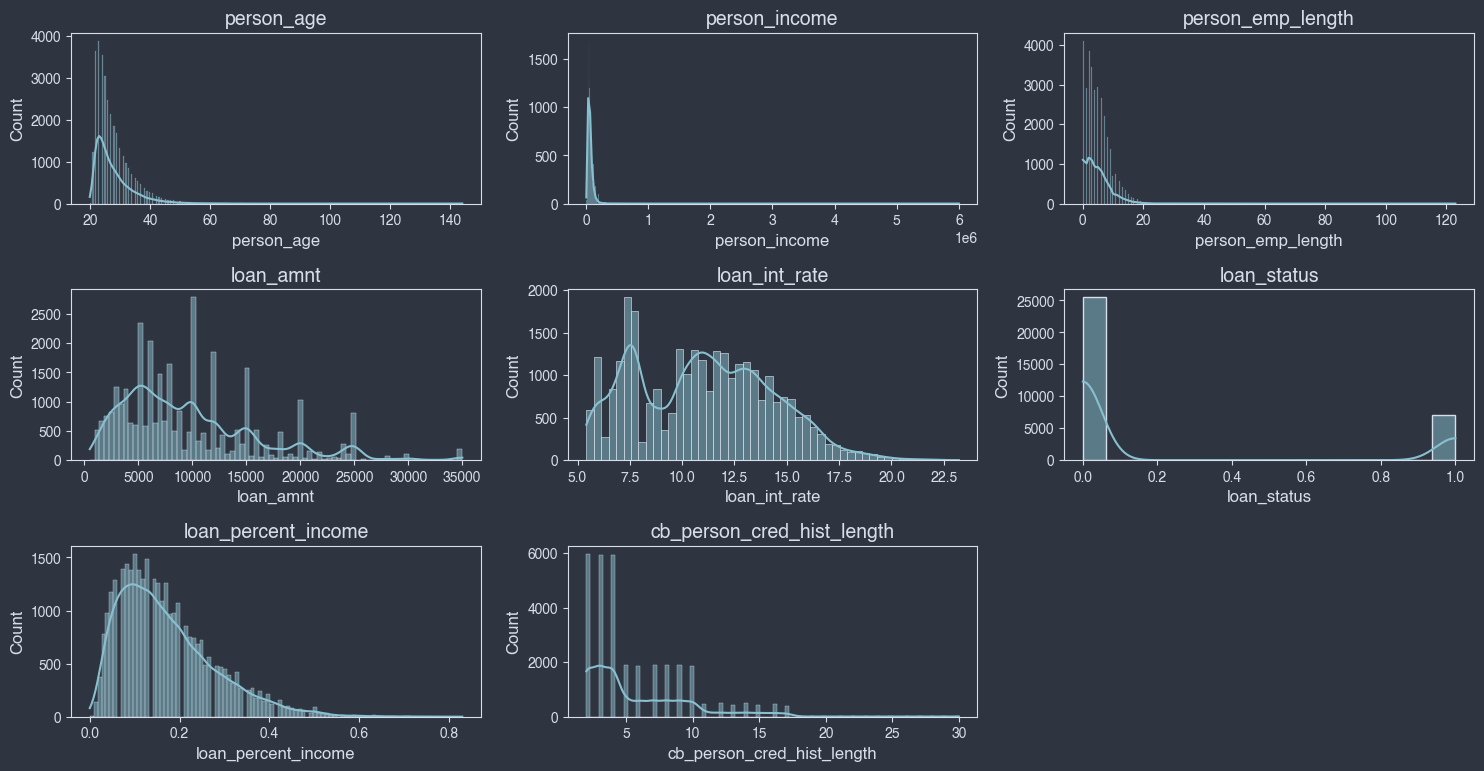

In [57]:
fig, axs = plt.subplots(4, 3, figsize=(15, 10))
axs = axs.flatten()


for index, col in enumerate(data.select_dtypes(include='number').columns):
    sns.histplot(data[col], ax=axs[index], kde=True)
    axs[index].set_title(col)

for ax in axs[len(data.select_dtypes(include='number').columns):]:
    ax.remove()

plt.tight_layout()
plt.show()

Correlation between Numerical Features

<Axes: >

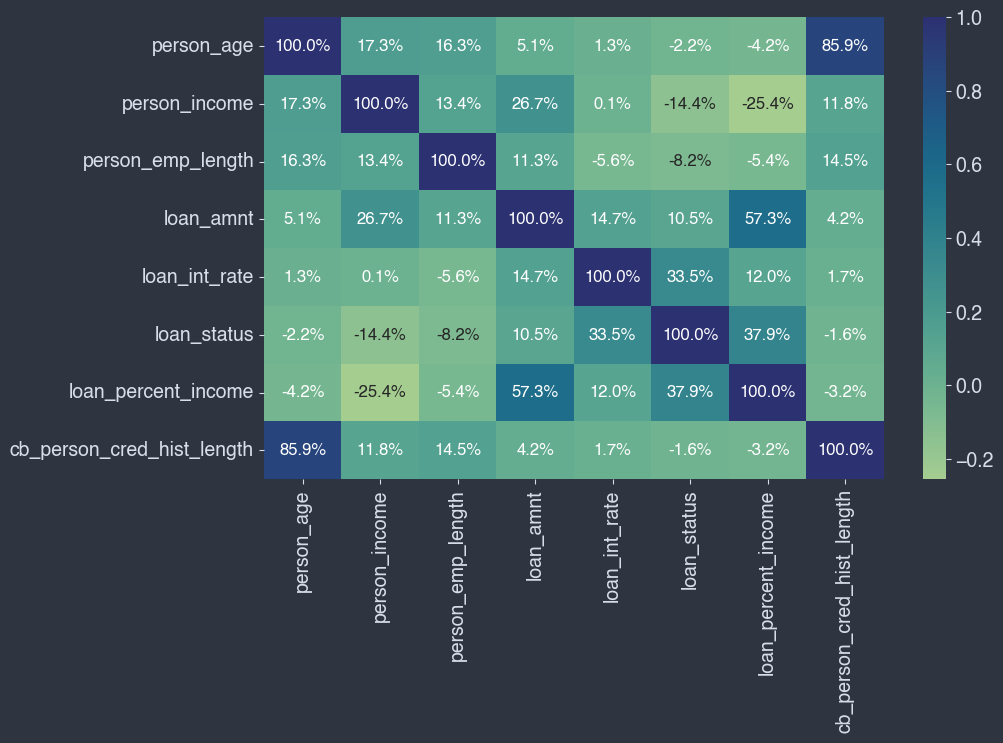

In [58]:
corr_mat = data.select_dtypes(include=['number']).corr()
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams['figure.dpi'] = 100
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
sns.heatmap(corr_mat, annot=True, fmt=".1%", cmap="crest")

### **Preprocessing Steps**

**Bye Bye Bye Missing Value** <br> 
Missing values in `person_emp_length` and `loan_int_rate` were imputed using the median.

In [59]:
from sklearn.impute import SimpleImputer
median_imputer = SimpleImputer(strategy='median')

In [60]:
data['person_emp_length'] = median_imputer.fit_transform(data[['person_emp_length']])
data['loan_int_rate'] = median_imputer.fit_transform(data[['loan_int_rate']])
data.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

**Skew Transform** <br>
We will proceed with the log transformation for <br> 
person_income, person_emp_length, loan_amnt, loan_percent_income, and cb_person_cred_hist_length <br>
because |skew| > 1

In [61]:
columns_to_transform = ['person_income', 'loan_amnt', 'person_emp_length','loan_percent_income','cb_person_cred_hist_length']

for column in columns_to_transform:
    data[f'{column}_sqrt'] = np.sqrt(data[column])
    data[f'{column}_log'] = np.log1p(data[column])
skewness_before = data[columns_to_transform].apply(skew)
skewness_after_sqrt = data[[f'{column}_sqrt' for column in columns_to_transform]].apply(skew)
skewness_after_log = data[[f'{column}_log' for column in columns_to_transform]].apply(skew)

print("Skewness before transformation:")
print(skewness_before)
print("\nSkewness after square root transformation:")
print(skewness_after_sqrt)
print("\nSkewness after log transformation:")
print(skewness_after_log)

Skewness before transformation:
person_income                 32.863836
loan_amnt                      1.192423
person_emp_length              2.662756
loan_percent_income            1.064620
cb_person_cred_hist_length     1.661714
dtype: float64

Skewness after square root transformation:
person_income_sqrt                 2.792531
loan_amnt_sqrt                     0.417006
person_emp_length_sqrt            -0.179543
loan_percent_income_sqrt           0.290940
cb_person_cred_hist_length_sqrt    0.896233
dtype: float64

Skewness after log transformation:
person_income_log                 0.155987
loan_amnt_log                    -0.447485
person_emp_length_log            -0.472792
loan_percent_income_log           0.817245
cb_person_cred_hist_length_log    0.487853
dtype: float64


Log Method is Great ! <br> The log transformation has significantly reduced the skewness for all features, bringing them closer to a normal distribution compared to the square root transformation.

In [62]:
data_transformed = data.drop(columns=['person_income', 'person_emp_length', 'loan_amnt', 'loan_percent_income', 'cb_person_cred_hist_length','person_income_sqrt', 'person_emp_length_sqrt', 'loan_amnt_sqrt', 'loan_percent_income_sqrt', 'cb_person_cred_hist_length_sqrt'])

In [63]:
data_transformed.head()

,person_age,person_home_ownership,loan_intent,loan_int_rate,loan_status,cb_person_default_on_file,person_income_log,loan_amnt_log,person_emp_length_log,loan_percent_income_log,cb_person_cred_hist_length_log
0,22,RENT,PERSONAL,16.02,1,Y,10.985310,10.463132,4.820282,0.463734,1.386294
1,21,OWN,EDUCATION,11.14,0,N,9.169623,6.908755,1.791759,0.095310,1.098612
2,25,MORTGAGE,MEDICAL,12.87,1,N,9.169623,8.612685,0.693147,0.451076,1.386294
3,23,RENT,MEDICAL,15.23,1,N,11.089821,10.463132,1.609438,0.425268,1.098612
4,24,RENT,MEDICAL,14.27,1,Y,10.904138,10.463132,2.197225,0.438255,1.609438


Label encoding for categorical features

In [64]:
label_encoder = LabelEncoder()

# Encode categorical features
data_transformed['person_home_ownership'] = label_encoder.fit_transform(data['person_home_ownership'])
data_transformed['loan_intent'] = label_encoder.fit_transform(data['loan_intent'])
data_transformed['cb_person_default_on_file'] = label_encoder.fit_transform(data['cb_person_default_on_file'])

In [65]:
data_transformed.head()

,person_age,person_home_ownership,loan_intent,loan_int_rate,loan_status,cb_person_default_on_file,person_income_log,loan_amnt_log,person_emp_length_log,loan_percent_income_log,cb_person_cred_hist_length_log
0,22,3,4,16.02,1,1,10.985310,10.463132,4.820282,0.463734,1.386294
1,21,2,1,11.14,0,0,9.169623,6.908755,1.791759,0.095310,1.098612
2,25,0,3,12.87,1,0,9.169623,8.612685,0.693147,0.451076,1.386294
3,23,3,3,15.23,1,0,11.089821,10.463132,1.609438,0.425268,1.098612
4,24,3,3,14.27,1,1,10.904138,10.463132,2.197225,0.438255,1.609438


**Standard Scaler**<br>
Even after applying log transformation to reduce skewness, the numerical features can still have different scales (ranges). Standardizing these features using a Standard Scaler ensures that they are on a common scale,

In [66]:
scaler = StandardScaler()
numerical_features_log = [
    'person_income_log', 
    'person_age',  # 'person_age_log' is not transformed based on our final decision
    'person_emp_length_log', 
    'loan_amnt_log', 
    'loan_int_rate', 
    'loan_percent_income_log', 
    'cb_person_cred_hist_length_log'
]
data_transformed[numerical_features_log] = scaler.fit_transform(data_transformed[numerical_features_log])

### Train-Test Split

In [67]:
X = data_transformed.drop(columns=['loan_status'])
y = data_transformed['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In credit risk assessment, default cases are much rarer than non-default ones, causing traditional models to favor the majority class. To fix this, we'll use Balanced Random Forest (BRF) to balance the scales and boost our model's accuracy!

In [68]:
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
brf.fit(X_train, y_train)
y_pred = brf.predict(X_test)

### Model Training and Evaluation

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from imblearn.ensemble import BalancedRandomForestClassifier
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import pandas as pd
from sklearn.metrics import roc_curve, auc


##### Optuna Optimization



In this section, we will train several machine learning models and evaluate their performance. Here's what we'll do:

1. **Logistic Regression**: A simple yet effective model for binary classification.
2. **K-Nearest Neighbors (KNN)**: A model that classifies based on the closest data points.
3. **Naive Bayes**: A probabilistic model based on Bayes' theorem.
4. **Support Vector Machine (SVM)**: A powerful model for classification tasks.
5. **Random Forest**: An ensemble model that builds multiple decision trees.
6. **XGBoost**: A high-performance gradient boosting model.
7. **LightGBM**: Another gradient boosting model known for its speed and efficiency.
8. **CatBoost**: A gradient boosting model that handles categorical features well.

Before training, we'll use Optuna to fine-tune the hyperparameters for each model. This will help us find the best settings for optimal performance. We'll evaluate each model using accuracy, F1 score, and confusion matrix to see how well they perform on the test data.


In [70]:
best_results = {}
trained_models = {}

def objective(trial):
    classifier_name = trial.suggest_categorical('classifier', [
        'Logistic Regression', 'KNN', 'Naive Bayes', 'SVM', 'Random Forest', 'XGBoost', 'LightGBM', 'CatBoost'])
    
    if classifier_name == 'Logistic Regression':
        C = trial.suggest_loguniform('lr_C', 1e-5, 1e2)
        model = LogisticRegression(C=C, max_iter=1000)
        
    elif classifier_name == 'KNN':
        n_neighbors = trial.suggest_int('n_neighbors', 2, 50)
        model = KNeighborsClassifier(n_neighbors=n_neighbors)
        
    elif classifier_name == 'Naive Bayes':
        model = GaussianNB()
        
    elif classifier_name == 'SVM':
        C = trial.suggest_loguniform('svc_C', 1e-5, 1e2)
        model = SVC(C=C, gamma='auto', probability=True)
        
    elif classifier_name == 'Random Forest':
        n_estimators = trial.suggest_int('rf_n_estimators', 10, 300)
        max_depth = trial.suggest_int('rf_max_depth', 2, 32)
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
        
    elif classifier_name == 'XGBoost':
        n_estimators = trial.suggest_int('xgb_n_estimators', 10, 300)
        max_depth = trial.suggest_int('xgb_max_depth', 2, 32)
        learning_rate = trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.1)
        model = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
        
    elif classifier_name == 'LightGBM':
        n_estimators = trial.suggest_int('lgb_n_estimators', 10, 300)
        max_depth = trial.suggest_int('lgb_max_depth', 2, 32)
        learning_rate = trial.suggest_loguniform('lgb_learning_rate', 0.01, 0.1)
        model = lgb.LGBMClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
        
    elif classifier_name == 'CatBoost':
        n_estimators = trial.suggest_int('cb_n_estimators', 10, 300)
        learning_rate = trial.suggest_loguniform('cb_learning_rate', 0.01, 0.1)
        depth = trial.suggest_int('cb_depth', 2, 10)
        model = cb.CatBoostClassifier(n_estimators=n_estimators, learning_rate=learning_rate, depth=depth, verbose=0)
        
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    if classifier_name not in best_results or best_results[classifier_name]['accuracy'] < accuracy:
        best_results[classifier_name] = {
            'accuracy': accuracy,
            'params': trial.params
        }
        trained_models[classifier_name] = model
    
    return accuracy

# study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Best results for each classifier:")
for classifier_name, result in best_results.items():
    print(f"\nClassifier: {classifier_name}")
    print(f"Accuracy: {result['accuracy']}")
    print("Params:")
    for key, value in result['params'].items():
        print(f"    {key}: {value}")


[I 2024-07-31 23:57:59,890] A new study created in memory with name: no-name-4e40537f-41a8-4fdf-aa1f-a6194f3c8859


[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000726 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-07-31 23:58:02,504] Trial 0 finished with value: 0.923584471382538 and parameters: {'classifier': 'LightGBM', 'lgb_n_estimators': 258, 'lgb_max_depth': 9, 'lgb_learning_rate': 0.06741255260686055}. Best is trial 0 with value: 0.923584471382538.
[I 2024-07-31 23:58:02,516] Trial 1 finished with value: 0.8221574344023324 and parameters: {'classifier': 'Naive Bayes'}. Best is trial 0 with value: 0.923584471382538.
[I 2024-07-31 23:58:03,237] Trial 2 finished with value: 0.9234310265459568 and parameters: {'classifier': 'XGBoost', 'xgb_n_estimators': 254, 'xgb_max_depth': 6, 'xgb_learning_rate': 0.09547762499945303}. Best is trial 0 with value: 0.923584471382538.
[I 2024-07-31 23:59:22,438] Trial 3 finished with value: 0.7782722111400951 and parameters: {'classifier': 'SVM', 'svc_C': 0.0003448205373184614}. Best is trial 0 with value: 0.923584471382538.
[I 2024-07-31 23:59:22,720] Trial 4 finished with value: 0.8365812490409698 and parameters: {'classifier': 'Logistic Regression', 

[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630


[I 2024-07-31 23:59:28,083] Trial 7 finished with value: 0.9188276814485192 and parameters: {'classifier': 'LightGBM', 'lgb_n_estimators': 213, 'lgb_max_depth': 22, 'lgb_learning_rate': 0.017734902875396245}. Best is trial 0 with value: 0.923584471382538.
[I 2024-07-31 23:59:28,093] Trial 8 finished with value: 0.8221574344023324 and parameters: {'classifier': 'Naive Bayes'}. Best is trial 0 with value: 0.923584471382538.
[I 2024-07-31 23:59:28,247] Trial 9 finished with value: 0.8361209145312261 and parameters: {'classifier': 'Logistic Regression', 'lr_C': 0.12198116593342079}. Best is trial 0 with value: 0.923584471382538.


[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000682 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-07-31 23:59:28,948] Trial 10 finished with value: 0.918674236611938 and parameters: {'classifier': 'LightGBM', 'lgb_n_estimators': 299, 'lgb_max_depth': 3, 'lgb_learning_rate': 0.09430317193268153}. Best is trial 0 with value: 0.923584471382538.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-31 23:59:29,463] Trial 11 finished with value: 0.9203621298143317 and parameters: {'classifier': 'XGBoost', 'xgb_n_estimators': 269, 'xgb_max_depth': 4, 'xgb_learning_rate': 0.09684904615741588}. Best is trial 0 with value: 0.923584471382538.
[I 2024-07-31 23:59:30,744] Trial 12 finished with value: 0.9232775817093755 and parameters: {'classifier': 'XGBoost', 'xgb_n_estimators': 210, 'xgb_max_depth': 11, 'xgb_learning_rate': 0.057385120850398964}. Best is trial 0 with value: 0.923584471382538.
[I 2024-07-31 23:59:34,982] Trial 13 finished with value: 0.9087003222341569 and parameters: {'classifier': 'Random Forest', 'rf_n_estimators': 200, 'rf_max_depth': 10}. Best is trial 0 with value: 0.923584471382538.
[I 2024-07-31 23:59:35,575] Trial 14 finished with value: 0.8686512198864508 and parameters: {'classifier': 'KNN', 'n_neighbors': 22}. Best is trial 0 with value: 0.923584471382538.
[I 2024-07-31 23:59:36,452] Trial 15 finished with value: 0.9083934325609944 and parameters

[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630


[I 2024-07-31 23:59:37,350] Trial 17 finished with value: 0.8625134264232008 and parameters: {'classifier': 'KNN', 'n_neighbors': 50}. Best is trial 0 with value: 0.923584471382538.
[I 2024-07-31 23:59:38,101] Trial 18 finished with value: 0.9105416602731318 and parameters: {'classifier': 'Random Forest', 'rf_n_estimators': 22, 'rf_max_depth': 30}. Best is trial 0 with value: 0.923584471382538.
[I 2024-08-01 00:03:26,148] Trial 19 finished with value: 0.8953506214515882 and parameters: {'classifier': 'SVM', 'svc_C': 86.89585769776247}. Best is trial 0 with value: 0.923584471382538.


[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630


[I 2024-08-01 00:03:27,906] Trial 20 finished with value: 0.9237379162191193 and parameters: {'classifier': 'LightGBM', 'lgb_n_estimators': 193, 'lgb_max_depth': 31, 'lgb_learning_rate': 0.03909063764447567}. Best is trial 20 with value: 0.9237379162191193.


[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630


[I 2024-08-01 00:03:29,716] Trial 21 finished with value: 0.9234310265459568 and parameters: {'classifier': 'LightGBM', 'lgb_n_estimators': 203, 'lgb_max_depth': 31, 'lgb_learning_rate': 0.03980097585161082}. Best is trial 20 with value: 0.9237379162191193.


[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630


[I 2024-08-01 00:03:31,934] Trial 22 finished with value: 0.922970692036213 and parameters: {'classifier': 'LightGBM', 'lgb_n_estimators': 276, 'lgb_max_depth': 15, 'lgb_learning_rate': 0.04056605833916416}. Best is trial 20 with value: 0.9237379162191193.
[I 2024-08-01 00:03:35,010] Trial 23 finished with value: 0.9203621298143317 and parameters: {'classifier': 'XGBoost', 'xgb_n_estimators': 291, 'xgb_max_depth': 17, 'xgb_learning_rate': 0.028440208364289732}. Best is trial 20 with value: 0.9237379162191193.


[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630


[I 2024-08-01 00:03:35,881] Trial 24 finished with value: 0.921743133343563 and parameters: {'classifier': 'LightGBM', 'lgb_n_estimators': 102, 'lgb_max_depth': 32, 'lgb_learning_rate': 0.05420917118609797}. Best is trial 20 with value: 0.9237379162191193.


[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630


[I 2024-08-01 00:03:37,536] Trial 25 finished with value: 0.919901795304588 and parameters: {'classifier': 'LightGBM', 'lgb_n_estimators': 191, 'lgb_max_depth': 13, 'lgb_learning_rate': 0.0224588807196948}. Best is trial 20 with value: 0.9237379162191193.
[I 2024-08-01 00:03:37,719] Trial 26 finished with value: 0.8881387141322694 and parameters: {'classifier': 'XGBoost', 'xgb_n_estimators': 132, 'xgb_max_depth': 2, 'xgb_learning_rate': 0.03431676753639789}. Best is trial 20 with value: 0.9237379162191193.


[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630


[I 2024-08-01 00:03:38,915] Trial 27 finished with value: 0.9116157741292006 and parameters: {'classifier': 'LightGBM', 'lgb_n_estimators': 128, 'lgb_max_depth': 24, 'lgb_learning_rate': 0.011555932800941596}. Best is trial 20 with value: 0.9237379162191193.
[I 2024-08-01 00:03:39,040] Trial 28 finished with value: 0.8479361669479822 and parameters: {'classifier': 'CatBoost', 'cb_n_estimators': 10, 'cb_learning_rate': 0.012112465350743845, 'cb_depth': 2}. Best is trial 20 with value: 0.9237379162191193.
[I 2024-08-01 00:03:39,051] Trial 29 finished with value: 0.8221574344023324 and parameters: {'classifier': 'Naive Bayes'}. Best is trial 20 with value: 0.9237379162191193.
[I 2024-08-01 00:03:39,418] Trial 30 finished with value: 0.8625134264232008 and parameters: {'classifier': 'KNN', 'n_neighbors': 2}. Best is trial 20 with value: 0.9237379162191193.


[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630


[I 2024-08-01 00:03:41,572] Trial 31 finished with value: 0.922970692036213 and parameters: {'classifier': 'LightGBM', 'lgb_n_estimators': 229, 'lgb_max_depth': 32, 'lgb_learning_rate': 0.0336910850480159}. Best is trial 20 with value: 0.9237379162191193.


[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630


[I 2024-08-01 00:03:43,714] Trial 32 finished with value: 0.9234310265459568 and parameters: {'classifier': 'LightGBM', 'lgb_n_estimators': 241, 'lgb_max_depth': 26, 'lgb_learning_rate': 0.05071189050355607}. Best is trial 20 with value: 0.9237379162191193.
[I 2024-08-01 00:04:54,892] Trial 33 finished with value: 0.8872180451127819 and parameters: {'classifier': 'SVM', 'svc_C': 2.030733287516396}. Best is trial 20 with value: 0.9237379162191193.
[I 2024-08-01 00:04:55,145] Trial 34 finished with value: 0.7782722111400951 and parameters: {'classifier': 'Logistic Regression', 'lr_C': 1.172623234439233e-05}. Best is trial 20 with value: 0.9237379162191193.


[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630


[I 2024-08-01 00:04:56,917] Trial 35 finished with value: 0.9203621298143317 and parameters: {'classifier': 'LightGBM', 'lgb_n_estimators': 168, 'lgb_max_depth': 28, 'lgb_learning_rate': 0.02694184817438178}. Best is trial 20 with value: 0.9237379162191193.


[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630


[I 2024-08-01 00:04:59,087] Trial 36 finished with value: 0.9225103575264693 and parameters: {'classifier': 'LightGBM', 'lgb_n_estimators': 256, 'lgb_max_depth': 10, 'lgb_learning_rate': 0.05351093055680395}. Best is trial 20 with value: 0.9237379162191193.
[I 2024-08-01 00:04:59,100] Trial 37 finished with value: 0.8221574344023324 and parameters: {'classifier': 'Naive Bayes'}. Best is trial 20 with value: 0.9237379162191193.
[I 2024-08-01 00:04:59,212] Trial 38 finished with value: 0.8510050636796072 and parameters: {'classifier': 'CatBoost', 'cb_n_estimators': 11, 'cb_learning_rate': 0.09309883402488343, 'cb_depth': 2}. Best is trial 20 with value: 0.9237379162191193.
[I 2024-08-01 00:05:02,629] Trial 39 finished with value: 0.8557618536136259 and parameters: {'classifier': 'Random Forest', 'rf_n_estimators': 298, 'rf_max_depth': 3}. Best is trial 20 with value: 0.9237379162191193.
[I 2024-08-01 00:05:02,771] Trial 40 finished with value: 0.8367346938775511 and parameters: {'classif

[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630


[I 2024-08-01 00:05:04,972] Trial 41 finished with value: 0.9231241368727943 and parameters: {'classifier': 'LightGBM', 'lgb_n_estimators': 231, 'lgb_max_depth': 27, 'lgb_learning_rate': 0.04499820481905402}. Best is trial 20 with value: 0.9237379162191193.


[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630


[I 2024-08-01 00:05:06,673] Trial 42 finished with value: 0.9234310265459568 and parameters: {'classifier': 'LightGBM', 'lgb_n_estimators': 189, 'lgb_max_depth': 21, 'lgb_learning_rate': 0.05739416624102329}. Best is trial 20 with value: 0.9237379162191193.


[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000417 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630


[I 2024-08-01 00:05:08,947] Trial 43 finished with value: 0.9243516955654443 and parameters: {'classifier': 'LightGBM', 'lgb_n_estimators': 250, 'lgb_max_depth': 30, 'lgb_learning_rate': 0.07883548822057343}. Best is trial 43 with value: 0.9243516955654443.


[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630


[I 2024-08-01 00:05:11,232] Trial 44 finished with value: 0.9255792542580942 and parameters: {'classifier': 'LightGBM', 'lgb_n_estimators': 266, 'lgb_max_depth': 30, 'lgb_learning_rate': 0.08766161458612776}. Best is trial 44 with value: 0.9255792542580942.
[I 2024-08-01 00:05:13,986] Trial 45 finished with value: 0.918674236611938 and parameters: {'classifier': 'XGBoost', 'xgb_n_estimators': 179, 'xgb_max_depth': 28, 'xgb_learning_rate': 0.09786783422723641}. Best is trial 44 with value: 0.9255792542580942.


[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630


[I 2024-08-01 00:05:16,154] Trial 46 finished with value: 0.9251189197483505 and parameters: {'classifier': 'LightGBM', 'lgb_n_estimators': 275, 'lgb_max_depth': 18, 'lgb_learning_rate': 0.09970933850348664}. Best is trial 44 with value: 0.9255792542580942.


[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000619 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630


[I 2024-08-01 00:05:18,593] Trial 47 finished with value: 0.9257326990946755 and parameters: {'classifier': 'LightGBM', 'lgb_n_estimators': 275, 'lgb_max_depth': 18, 'lgb_learning_rate': 0.09900087157149898}. Best is trial 47 with value: 0.9257326990946755.


[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630


[I 2024-08-01 00:05:21,554] Trial 48 finished with value: 0.9249654749117692 and parameters: {'classifier': 'LightGBM', 'lgb_n_estimators': 297, 'lgb_max_depth': 29, 'lgb_learning_rate': 0.09347496592660215}. Best is trial 47 with value: 0.9257326990946755.


[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630


[I 2024-08-01 00:05:24,600] Trial 49 finished with value: 0.9237379162191193 and parameters: {'classifier': 'LightGBM', 'lgb_n_estimators': 293, 'lgb_max_depth': 19, 'lgb_learning_rate': 0.09646966757902849}. Best is trial 47 with value: 0.9257326990946755.


[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630


[I 2024-08-01 00:05:27,625] Trial 50 finished with value: 0.9240448058922818 and parameters: {'classifier': 'LightGBM', 'lgb_n_estimators': 272, 'lgb_max_depth': 18, 'lgb_learning_rate': 0.08132064599794352}. Best is trial 47 with value: 0.9257326990946755.


[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630


[I 2024-08-01 00:05:30,656] Trial 51 finished with value: 0.9238913610557005 and parameters: {'classifier': 'LightGBM', 'lgb_n_estimators': 272, 'lgb_max_depth': 17, 'lgb_learning_rate': 0.07921840259097383}. Best is trial 47 with value: 0.9257326990946755.


[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000776 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630


[I 2024-08-01 00:05:33,859] Trial 52 finished with value: 0.9255792542580942 and parameters: {'classifier': 'LightGBM', 'lgb_n_estimators': 278, 'lgb_max_depth': 18, 'lgb_learning_rate': 0.0983640626058178}. Best is trial 47 with value: 0.9257326990946755.


[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630


[I 2024-08-01 00:05:36,842] Trial 53 finished with value: 0.9240448058922818 and parameters: {'classifier': 'LightGBM', 'lgb_n_estimators': 299, 'lgb_max_depth': 28, 'lgb_learning_rate': 0.09859159574442085}. Best is trial 47 with value: 0.9257326990946755.


[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630


[I 2024-08-01 00:05:39,130] Trial 54 finished with value: 0.923584471382538 and parameters: {'classifier': 'LightGBM', 'lgb_n_estimators': 259, 'lgb_max_depth': 15, 'lgb_learning_rate': 0.08274634067928834}. Best is trial 47 with value: 0.9257326990946755.
[I 2024-08-01 00:07:07,779] Trial 55 finished with value: 0.7782722111400951 and parameters: {'classifier': 'SVM', 'svc_C': 2.0243599356049077e-05}. Best is trial 47 with value: 0.9257326990946755.


[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000975 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630


[I 2024-08-01 00:07:10,843] Trial 56 finished with value: 0.9234310265459568 and parameters: {'classifier': 'LightGBM', 'lgb_n_estimators': 276, 'lgb_max_depth': 21, 'lgb_learning_rate': 0.0985047807141376}. Best is trial 47 with value: 0.9257326990946755.


[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630


[I 2024-08-01 00:07:13,716] Trial 57 finished with value: 0.9234310265459568 and parameters: {'classifier': 'LightGBM', 'lgb_n_estimators': 247, 'lgb_max_depth': 29, 'lgb_learning_rate': 0.07113331119384929}. Best is trial 47 with value: 0.9257326990946755.
[I 2024-08-01 00:07:14,868] Trial 58 finished with value: 0.914991560533988 and parameters: {'classifier': 'Random Forest', 'rf_n_estimators': 27, 'rf_max_depth': 28}. Best is trial 47 with value: 0.9257326990946755.
[I 2024-08-01 00:07:16,084] Trial 59 finished with value: 0.8634340954426883 and parameters: {'classifier': 'KNN', 'n_neighbors': 49}. Best is trial 47 with value: 0.9257326990946755.


[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630


[I 2024-08-01 00:07:19,123] Trial 60 finished with value: 0.922970692036213 and parameters: {'classifier': 'LightGBM', 'lgb_n_estimators': 282, 'lgb_max_depth': 24, 'lgb_learning_rate': 0.08351185500220965}. Best is trial 47 with value: 0.9257326990946755.


[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630


[I 2024-08-01 00:07:21,392] Trial 61 finished with value: 0.9246585852386067 and parameters: {'classifier': 'LightGBM', 'lgb_n_estimators': 269, 'lgb_max_depth': 18, 'lgb_learning_rate': 0.08324228391688138}. Best is trial 47 with value: 0.9257326990946755.


[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630


[I 2024-08-01 00:07:23,858] Trial 62 finished with value: 0.9258861439312567 and parameters: {'classifier': 'LightGBM', 'lgb_n_estimators': 268, 'lgb_max_depth': 16, 'lgb_learning_rate': 0.08435734398942366}. Best is trial 62 with value: 0.9258861439312567.


[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630


[I 2024-08-01 00:07:26,388] Trial 63 finished with value: 0.9240448058922818 and parameters: {'classifier': 'LightGBM', 'lgb_n_estimators': 282, 'lgb_max_depth': 16, 'lgb_learning_rate': 0.09871168252875932}. Best is trial 62 with value: 0.9258861439312567.
[I 2024-08-01 00:07:26,404] Trial 64 finished with value: 0.8221574344023324 and parameters: {'classifier': 'Naive Bayes'}. Best is trial 62 with value: 0.9258861439312567.


[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630


[I 2024-08-01 00:07:28,631] Trial 65 finished with value: 0.9237379162191193 and parameters: {'classifier': 'LightGBM', 'lgb_n_estimators': 261, 'lgb_max_depth': 12, 'lgb_learning_rate': 0.06476605927226155}. Best is trial 62 with value: 0.9258861439312567.


[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630


[I 2024-08-01 00:07:31,676] Trial 66 finished with value: 0.9238913610557005 and parameters: {'classifier': 'LightGBM', 'lgb_n_estimators': 291, 'lgb_max_depth': 20, 'lgb_learning_rate': 0.08561670181840782}. Best is trial 62 with value: 0.9258861439312567.
[I 2024-08-01 00:07:33,573] Trial 67 finished with value: 0.9071658738683444 and parameters: {'classifier': 'CatBoost', 'cb_n_estimators': 161, 'cb_learning_rate': 0.010809439839838024, 'cb_depth': 10}. Best is trial 62 with value: 0.9258861439312567.


[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630


[I 2024-08-01 00:07:36,306] Trial 68 finished with value: 0.9243516955654443 and parameters: {'classifier': 'LightGBM', 'lgb_n_estimators': 264, 'lgb_max_depth': 18, 'lgb_learning_rate': 0.06593293023232161}. Best is trial 62 with value: 0.9258861439312567.
[I 2024-08-01 00:07:36,528] Trial 69 finished with value: 0.7782722111400951 and parameters: {'classifier': 'Logistic Regression', 'lr_C': 1.0938040560056252e-05}. Best is trial 62 with value: 0.9258861439312567.
[I 2024-08-01 00:09:12,834] Trial 70 finished with value: 0.8474758324382384 and parameters: {'classifier': 'SVM', 'svc_C': 0.034411833654453425}. Best is trial 62 with value: 0.9258861439312567.


[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630


[I 2024-08-01 00:09:15,549] Trial 71 finished with value: 0.923584471382538 and parameters: {'classifier': 'LightGBM', 'lgb_n_estimators': 246, 'lgb_max_depth': 17, 'lgb_learning_rate': 0.0770849728001126}. Best is trial 62 with value: 0.9258861439312567.


[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630


[I 2024-08-01 00:09:18,253] Trial 72 finished with value: 0.9237379162191193 and parameters: {'classifier': 'LightGBM', 'lgb_n_estimators': 264, 'lgb_max_depth': 13, 'lgb_learning_rate': 0.08840273893082427}. Best is trial 62 with value: 0.9258861439312567.


[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630


[I 2024-08-01 00:09:21,378] Trial 73 finished with value: 0.9238913610557005 and parameters: {'classifier': 'LightGBM', 'lgb_n_estimators': 297, 'lgb_max_depth': 30, 'lgb_learning_rate': 0.07316788771331552}. Best is trial 62 with value: 0.9258861439312567.


[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630


[I 2024-08-01 00:09:24,817] Trial 74 finished with value: 0.923584471382538 and parameters: {'classifier': 'LightGBM', 'lgb_n_estimators': 282, 'lgb_max_depth': 23, 'lgb_learning_rate': 0.08931695737780378}. Best is trial 62 with value: 0.9258861439312567.


[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630


[I 2024-08-01 00:09:26,723] Trial 75 finished with value: 0.922970692036213 and parameters: {'classifier': 'LightGBM', 'lgb_n_estimators': 226, 'lgb_max_depth': 15, 'lgb_learning_rate': 0.08818392375823583}. Best is trial 62 with value: 0.9258861439312567.


[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-08-01 00:09:27,271] Trial 76 finished with value: 0.9014884149148381 and parameters: {'classifier': 'LightGBM', 'lgb_n_estimators': 245, 'lgb_max_depth': 2, 'lgb_learning_rate': 0.06310825224454338}. Best is trial 62 with value: 0.9258861439312567.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-01 00:09:28,184] Trial 77 finished with value: 0.8692649992327758 and parameters: {'classifier': 'KNN', 'n_neighbors': 26}. Best is trial 62 with value: 0.9258861439312567.


[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630


[I 2024-08-01 00:09:28,741] Trial 78 finished with value: 0.919288015958263 and parameters: {'classifier': 'LightGBM', 'lgb_n_estimators': 55, 'lgb_max_depth': 19, 'lgb_learning_rate': 0.07589143999167464}. Best is trial 62 with value: 0.9258861439312567.
[I 2024-08-01 00:09:33,743] Trial 79 finished with value: 0.9145312260242443 and parameters: {'classifier': 'Random Forest', 'rf_n_estimators': 128, 'rf_max_depth': 18}. Best is trial 62 with value: 0.9258861439312567.
[I 2024-08-01 00:09:33,779] Trial 80 finished with value: 0.8221574344023324 and parameters: {'classifier': 'Naive Bayes'}. Best is trial 62 with value: 0.9258861439312567.


[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630


[I 2024-08-01 00:09:36,919] Trial 81 finished with value: 0.9243516955654443 and parameters: {'classifier': 'LightGBM', 'lgb_n_estimators': 261, 'lgb_max_depth': 18, 'lgb_learning_rate': 0.06826100763010604}. Best is trial 62 with value: 0.9258861439312567.


[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630


[I 2024-08-01 00:09:40,842] Trial 82 finished with value: 0.9238913610557005 and parameters: {'classifier': 'LightGBM', 'lgb_n_estimators': 269, 'lgb_max_depth': 19, 'lgb_learning_rate': 0.09870295109905797}. Best is trial 62 with value: 0.9258861439312567.


[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-08-01 00:09:43,773] Trial 83 finished with value: 0.9243516955654443 and parameters: {'classifier': 'LightGBM', 'lgb_n_estimators': 283, 'lgb_max_depth': 6, 'lgb_learning_rate': 0.08756984878241045}. Best is trial 62 with value: 0.9258861439312567.


[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001554 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630


[I 2024-08-01 00:09:47,625] Trial 84 finished with value: 0.9237379162191193 and parameters: {'classifier': 'LightGBM', 'lgb_n_estimators': 254, 'lgb_max_depth': 16, 'lgb_learning_rate': 0.07793407494931075}. Best is trial 62 with value: 0.9258861439312567.


[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630


[I 2024-08-01 00:09:51,349] Trial 85 finished with value: 0.9237379162191193 and parameters: {'classifier': 'LightGBM', 'lgb_n_estimators': 285, 'lgb_max_depth': 31, 'lgb_learning_rate': 0.0896226993750867}. Best is trial 62 with value: 0.9258861439312567.
[I 2024-08-01 00:09:52,178] Trial 86 finished with value: 0.7782722111400951 and parameters: {'classifier': 'XGBoost', 'xgb_n_estimators': 27, 'xgb_max_depth': 22, 'xgb_learning_rate': 0.012031185758521816}. Best is trial 62 with value: 0.9258861439312567.
[I 2024-08-01 00:09:55,222] Trial 87 finished with value: 0.9119226638023631 and parameters: {'classifier': 'CatBoost', 'cb_n_estimators': 281, 'cb_learning_rate': 0.026999522794521277, 'cb_depth': 5}. Best is trial 62 with value: 0.9258861439312567.


[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630


[I 2024-08-01 00:09:58,596] Trial 88 finished with value: 0.9240448058922818 and parameters: {'classifier': 'LightGBM', 'lgb_n_estimators': 270, 'lgb_max_depth': 18, 'lgb_learning_rate': 0.062237270051492564}. Best is trial 62 with value: 0.9258861439312567.
[I 2024-08-01 00:09:58,982] Trial 89 finished with value: 0.8301365659045573 and parameters: {'classifier': 'Logistic Regression', 'lr_C': 0.0014334488216549738}. Best is trial 62 with value: 0.9258861439312567.


[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000808 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630


[I 2024-08-01 00:10:01,841] Trial 90 finished with value: 0.922970692036213 and parameters: {'classifier': 'LightGBM', 'lgb_n_estimators': 210, 'lgb_max_depth': 14, 'lgb_learning_rate': 0.0735115592171505}. Best is trial 62 with value: 0.9258861439312567.


[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630


[I 2024-08-01 00:10:04,374] Trial 91 finished with value: 0.923584471382538 and parameters: {'classifier': 'LightGBM', 'lgb_n_estimators': 263, 'lgb_max_depth': 18, 'lgb_learning_rate': 0.06706199602575465}. Best is trial 62 with value: 0.9258861439312567.


[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000741 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630


[I 2024-08-01 00:10:06,666] Trial 92 finished with value: 0.9231241368727943 and parameters: {'classifier': 'LightGBM', 'lgb_n_estimators': 237, 'lgb_max_depth': 20, 'lgb_learning_rate': 0.08854532510473016}. Best is trial 62 with value: 0.9258861439312567.


[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630


[I 2024-08-01 00:10:09,161] Trial 93 finished with value: 0.9231241368727943 and parameters: {'classifier': 'LightGBM', 'lgb_n_estimators': 253, 'lgb_max_depth': 17, 'lgb_learning_rate': 0.06837725963858668}. Best is trial 62 with value: 0.9258861439312567.


[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000677 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630


[I 2024-08-01 00:10:11,783] Trial 94 finished with value: 0.919288015958263 and parameters: {'classifier': 'LightGBM', 'lgb_n_estimators': 269, 'lgb_max_depth': 30, 'lgb_learning_rate': 0.015257588279465509}. Best is trial 62 with value: 0.9258861439312567.


[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630


[I 2024-08-01 00:10:14,536] Trial 95 finished with value: 0.924198250728863 and parameters: {'classifier': 'LightGBM', 'lgb_n_estimators': 290, 'lgb_max_depth': 16, 'lgb_learning_rate': 0.09262588928322296}. Best is trial 62 with value: 0.9258861439312567.


[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630


[I 2024-08-01 00:10:17,239] Trial 96 finished with value: 0.9243516955654443 and parameters: {'classifier': 'LightGBM', 'lgb_n_estimators': 300, 'lgb_max_depth': 26, 'lgb_learning_rate': 0.08073637067339419}. Best is trial 62 with value: 0.9258861439312567.
[I 2024-08-01 00:11:47,170] Trial 97 finished with value: 0.8272211140095136 and parameters: {'classifier': 'SVM', 'svc_C': 0.010193481633897081}. Best is trial 62 with value: 0.9258861439312567.


[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001955 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630


[I 2024-08-01 00:11:49,393] Trial 98 finished with value: 0.9232775817093755 and parameters: {'classifier': 'LightGBM', 'lgb_n_estimators': 257, 'lgb_max_depth': 21, 'lgb_learning_rate': 0.09995105852086303}. Best is trial 62 with value: 0.9258861439312567.
[I 2024-08-01 00:11:49,876] Trial 99 finished with value: 0.871873561454657 and parameters: {'classifier': 'KNN', 'n_neighbors': 5}. Best is trial 62 with value: 0.9258861439312567.


Best results for each classifier:

Classifier: LightGBM
Accuracy: 0.9258861439312567
Params:
    classifier: LightGBM
    lgb_n_estimators: 268
    lgb_max_depth: 16
    lgb_learning_rate: 0.08435734398942366

Classifier: Naive Bayes
Accuracy: 0.8221574344023324
Params:
    classifier: Naive Bayes

Classifier: XGBoost
Accuracy: 0.9234310265459568
Params:
    classifier: XGBoost
    xgb_n_estimators: 254
    xgb_max_depth: 6
    xgb_learning_rate: 0.09547762499945303

Classifier: SVM
Accuracy: 0.8953506214515882
Params:
    classifier: SVM
    svc_C: 86.89585769776247

Classifier: Logistic Regression
Accuracy: 0.8367346938775511
Params:
    classifier: Logistic Regression
    lr_C: 70.83692441634204

Classifier: CatBoost
Accuracy: 0.922356912689888
Params:
    classifier: CatBoost
    cb_n_estimators: 296
    cb_learning_rate: 0.05987221578876356
    cb_depth: 8

Classifier: Random Forest
Accuracy: 0.914991560533988
Params:
    classifier: Random Forest
    rf_n_estimators: 27
    rf_ma

#### Hyperparameter Tuning Summary

used Optuna to fine-tune the hyperparameters for each of our models. Here are the optimal parameters found for each classifier:

| Classifier           | Parameters                                                           |
|----------------------|----------------------------------------------------------------------|
| **LightGBM**         | lgb_n_estimators: 268<br>lgb_max_depth: 16<br>lgb_learning_rate: 0.0844 |
| **Naive Bayes**      | No hyperparameters to tune.                                          |
| **XGBoost**          | xgb_n_estimators: 254<br>xgb_max_depth: 6<br>xgb_learning_rate: 0.0955 |
| **SVM**              | svc_C: 86.896                                                        |
| **Logistic Regression** | lr_C: 70.837                                                      |
| **CatBoost**         | cb_n_estimators: 296<br>cb_learning_rate: 0.0599<br>cb_depth: 8      |
| **Random Forest**    | rf_n_estimators: 27<br>rf_max_depth: 28                              |
| **KNN**              | n_neighbors: 5                                                       |

These optimal parameters were crucial in enhancing the performance of our models, showing the importance of hyperparameter tuning in machine learning.


### Evaluate Models

In [71]:
def evaluate_model(model, model_name):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_score = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred, average='macro')
    conf_matrix = confusion_matrix(y_test, y_test_pred)
    class_report = classification_report(y_test, y_test_pred)
    
    return {
        'Model': model_name,
        'Train Score': train_score,
        'Test Accuracy': test_accuracy,
        'Test F1 Score (Macro)': test_f1,
        'Confusion Matrix': conf_matrix,
        'Classification Report': class_report
    }

# Evaluate all moels with the best parameters
results = []

for classifier_name, model in trained_models.items():
    model_results = evaluate_model(model, classifier_name)
    results.append(model_results)

results_df = pd.DataFrame(results)

print(results_df[['Model', 'Train Score', 'Test Accuracy', 'Test F1 Score (Macro)']])
for result in results:
    print(f"\nModel: {result['Model']}")
    print("Confusion Matrix:")
    print(result['Confusion Matrix'])
    print("\nClassification Report:")
    print(result['Classification Report'])


                 Model  Train Score  Test Accuracy  Test F1 Score (Macro)
0             LightGBM     0.949087       0.925886               0.881305
1          Naive Bayes     0.826657       0.822157               0.738238
2              XGBoost     0.945711       0.923431               0.877594
3                  SVM     0.928215       0.895351               0.830919
4  Logistic Regression     0.841659       0.836735               0.719517
5             CatBoost     0.938267       0.922357               0.874399
6        Random Forest     0.997468       0.914992               0.862230
7                  KNN     0.906001       0.871874               0.788212

Model: LightGBM
Confusion Matrix:
[[5014   58]
 [ 425 1020]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      5072
           1       0.95      0.71      0.81      1445

    accuracy                           0.93      6517
   macro avg       0.93      0

In [78]:
results_df.loc[:, results_df.columns != 'Classification Report']


,Model,Train Score,Test Accuracy,Test F1 Score (Macro),Confusion Matrix
0,LightGBM,0.949087,0.925886,0.881305,"[[5014, 58], [425, 1020]]"
1,Naive Bayes,0.826657,0.822157,0.738238,"[[4524, 548], [611, 834]]"
2,XGBoost,0.945711,0.923431,0.877594,"[[5003, 69], [430, 1015]]"
3,SVM,0.928215,0.895351,0.830919,"[[4929, 143], [539, 906]]"
4,Logistic Regression,0.841659,0.836735,0.719517,"[[4833, 239], [825, 620]]"
5,CatBoost,0.938267,0.922357,0.874399,"[[5019, 53], [453, 992]]"
6,Random Forest,0.997468,0.914992,0.862230,"[[4998, 74], [480, 965]]"
7,KNN,0.906001,0.871874,0.788212,"[[4889, 183], [652, 793]]"


#### Model Performance Summary

Here’s a fun and human-readable breakdown of how our models performed in predicting loan defaults:

###### LightGBM
- **Train Score**: 0.9491 - Almost perfect on training data!
- **Test Accuracy**: 0.9259 - High accuracy on new data.
- **Test F1 Score (Macro)**: 0.8813 - Excellent balance between precision and recall.
- **Confusion Matrix**: [[5014, 58], [425, 1020]] - It got most right, with few mistakes!

###### Naive Bayes
- **Train Score**: 0.8267 - Pretty good on training data.
- **Test Accuracy**: 0.8222 - Still solid on new data.
- **Test F1 Score (Macro)**: 0.7382 - Good, but there's room for improvement.
- **Confusion Matrix**: [[4524, 548], [611, 834]] - Some hits and misses, but not bad!

###### XGBoost
- **Train Score**: 0.9457 - Almost aced the training data!
- **Test Accuracy**: 0.9234 - Very high accuracy on test data.
- **Test F1 Score (Macro)**: 0.8776 - Balanced performance.
- **Confusion Matrix**: [[5003, 69], [430, 1015]] - Mostly accurate with few errors.

##### SVM
- **Train Score**: 0.9282 - Strong on training data.
- **Test Accuracy**: 0.8954 - Impressive on new data.
- **Test F1 Score (Macro)**: 0.8309 - Good balance overall.
- **Confusion Matrix**: [[4929, 143], [539, 906]] - Did well, though some mistakes.

###### Logistic Regression
- **Train Score**: 0.8417 - Decent on training data.
- **Test Accuracy**: 0.8367 - Consistent performance.
- **Test F1 Score (Macro)**: 0.7195 - Could be better balanced.
- **Confusion Matrix**: [[4833, 239], [825, 620]] - Accurate but with notable errors.

###### CatBoost
- **Train Score**: 0.9383 - Nearly perfect on training data.
- **Test Accuracy**: 0.9224 - Very accurate on new data.
- **Test F1 Score (Macro)**: 0.8744 - Well-balanced predictions.
- **Confusion Matrix**: [[5019, 53], [453, 992]] - Nailed it with few errors!

#### Random Forest
- **Train Score**: 0.9975 - Almost flawless on training data.
- **Test Accuracy**: 0.9150 - Very accurate on test data.
- **Test F1 Score (Macro)**: 0.8622 - Balanced performance.
- **Confusion Matrix**: [[4998, 74], [480, 965]] - Mostly correct with minor mistakes.

##### KNN
- **Train Score**: 0.9060 - Strong on training data.
- **Test Accuracy**: 0.8719 - Good performance on new data.
- **Test F1 Score (Macro)**: 0.7882 - Decent balance.
- **Confusion Matrix**: [[4889, 183], [652, 793]] - Did well but had some errors.

#### Summary
- **LightGBM and XGBoost**: Top performers with high accuracy and well-balanced scores.
- **CatBoost and Random Forest**: Also excellent, showing strong, reliable predictions.
- **SVM and KNN**: Good performance but not as stellar as the top models.
- **Naive Bayes and Logistic Regression**: Decent, but there’s room for improvement, especially in balancing precision and recall.

Each model brings its strengths to the table, but LightGBM and XGBoost stand out as the champions of this competition. Great job!

Feature Importance

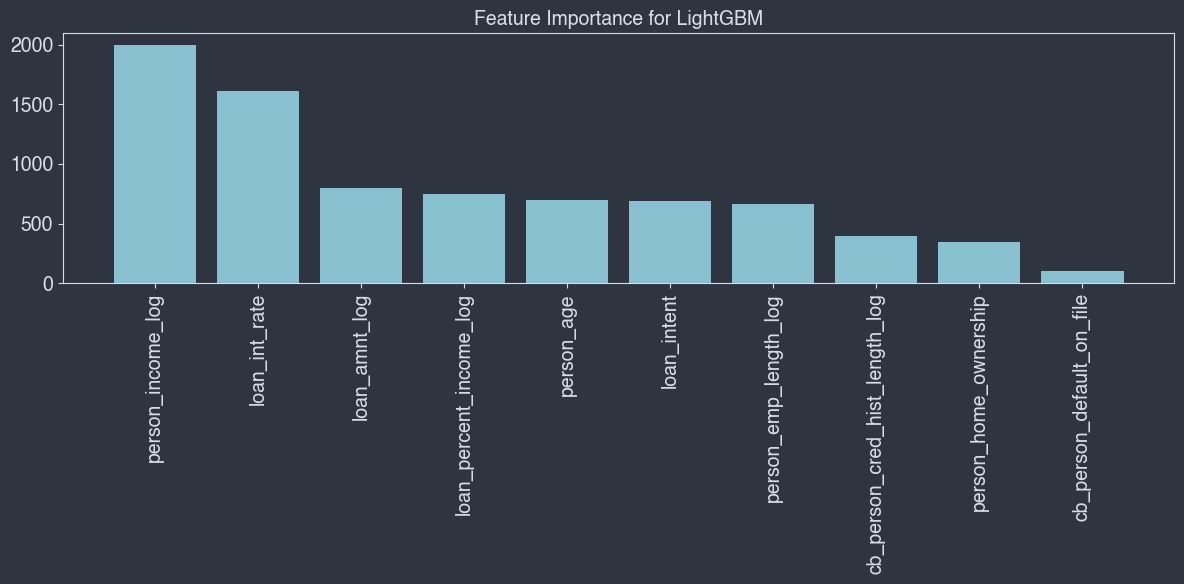

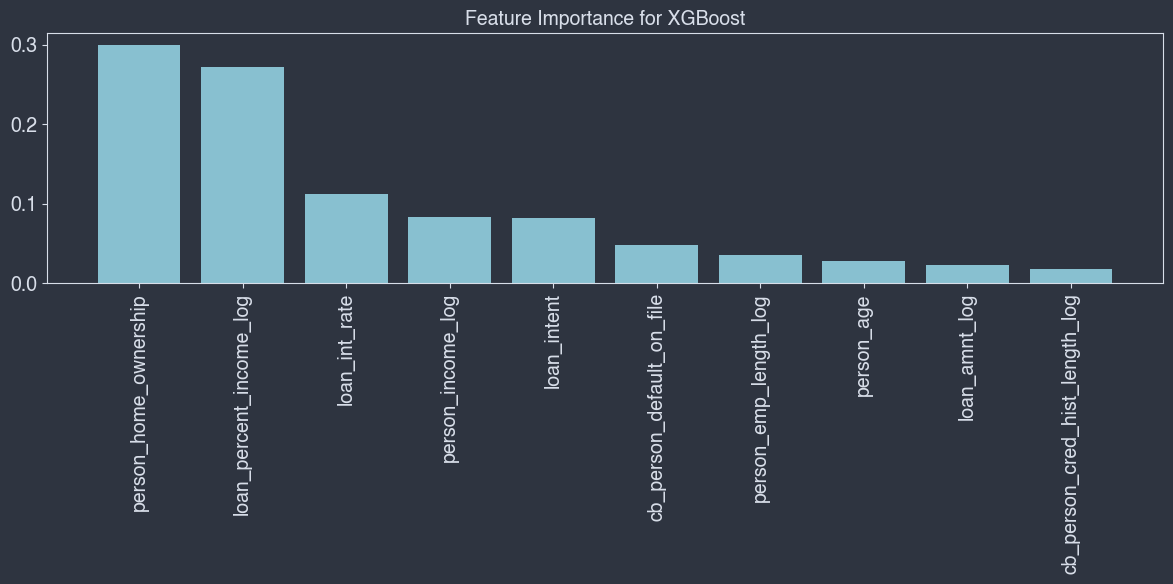

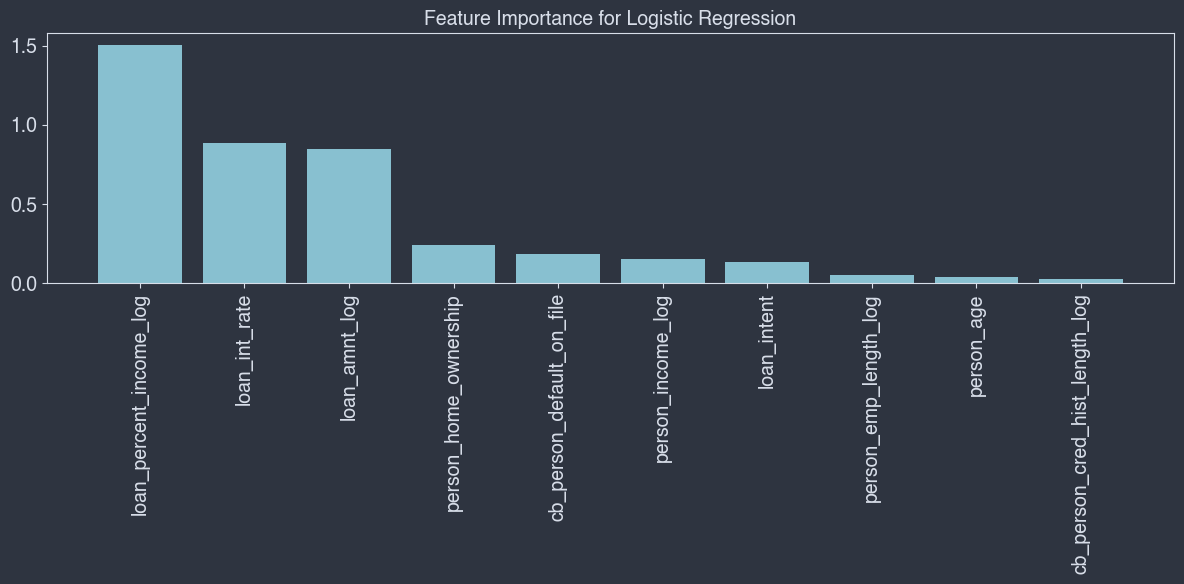

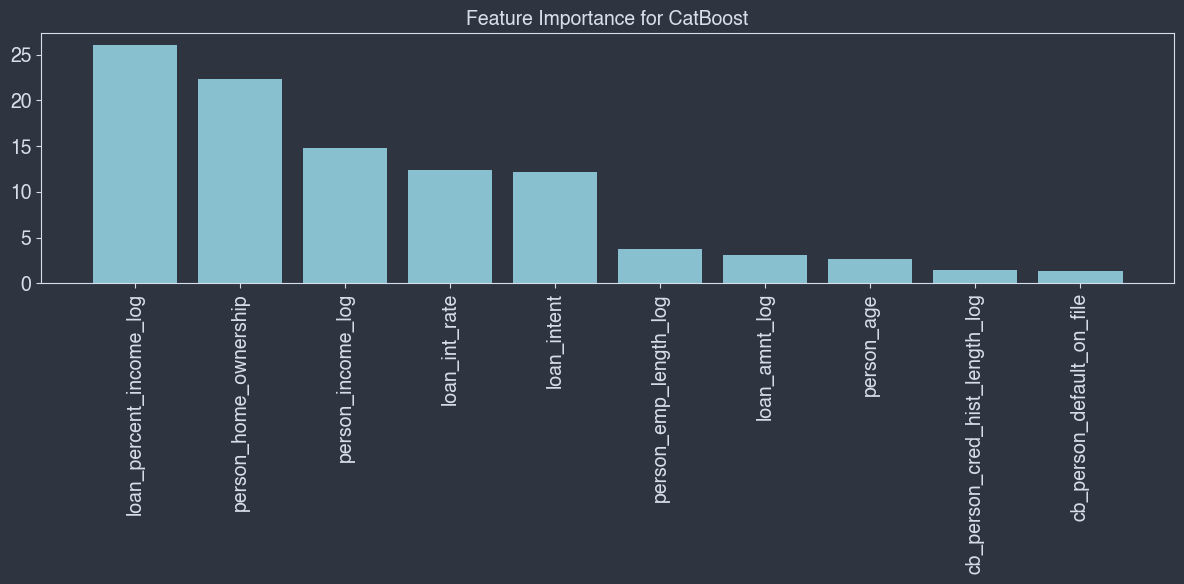

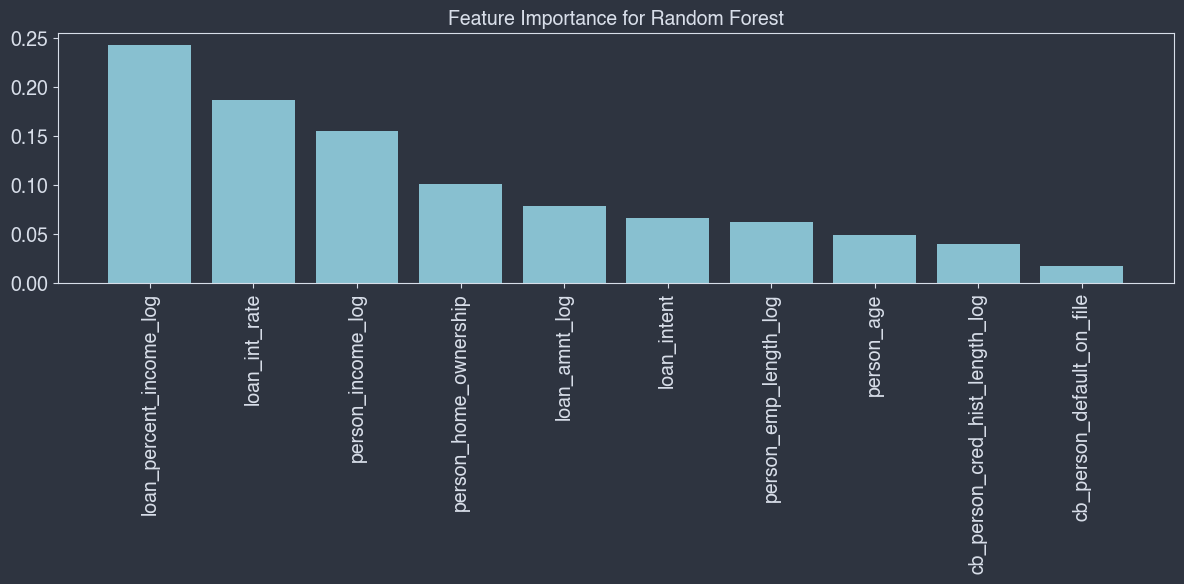

In [75]:
def plot_feature_importance(model, model_name, feature_names):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_[0])
    else:
        return  

    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(12, 6))
    plt.title(f"Feature Importance for {model_name}")
    plt.bar(range(len(importances)), importances[indices], align="center")
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()


for classifier_name, model in trained_models.items():
    plot_feature_importance(model, classifier_name, X.columns)


#### Feature Importance Analysis

Let's dive into the feature importance of our different models and see which factors they consider the most important for predicting loan defaults.

##### LightGBM Feature Importance

- **person_income_log**: This is the log-transformed income of the individual, and it's the superstar here! It plays a crucial role in predicting whether someone will default on their loan.
- **loan_int_rate**: The interest rate of the loan comes in second. High interest rates can really make it tough to keep up with payments.
- **loan_amnt_log**: The log-transformed loan amount is also vital. The bigger the loan, the bigger the risk!
- **loan_percent_income_log**: This shows how much of your income goes towards the loan. A high percentage can be a red flag for financial strain.

##### Random Forest Feature Importance

- **loan_percent_income_log**: This log-transformed feature takes the crown here. It’s crucial to know how much of your income is eaten up by loan payments.
- **loan_int_rate**: Interest rates are super important. They can make or break your ability to repay.
- **person_income_log**: Income matters a lot. The more you earn, the better your chances of staying on top of payments.
- **person_home_ownership**: Owning a home is a big deal. It indicates stability and financial health.


##### Logistic Regression Feature Importance

- **loan_percent_income_log**: The most significant factor here. It’s all about how much of your income is going towards the loan.
- **loan_int_rate**: High interest rates can be a killer, making this the second most important feature.
- **loan_amnt_log**: The size of the loan matters. Bigger loans mean bigger risks.


##### XGBoost Feature Importance

- **person_home_ownership**: Owning a home is the top factor. It shows financial stability and reduces default risk.
- **loan_percent_income_log**: How much of your income is used for loan payments is super important.
- **loan_int_rate**: Interest rates come in third. They significantly affect your ability to keep up with payments.


##### CatBoost Feature Importance

- **loan_percent_income_log**: This feature rules here, indicating how much of your income goes to loan payments.
- **person_home_ownership**: Home ownership is a solid indicator of financial health.
- **person_income_log**: Income is crucial. More income generally means better loan repayment capabilities.


ROC AUC Curves

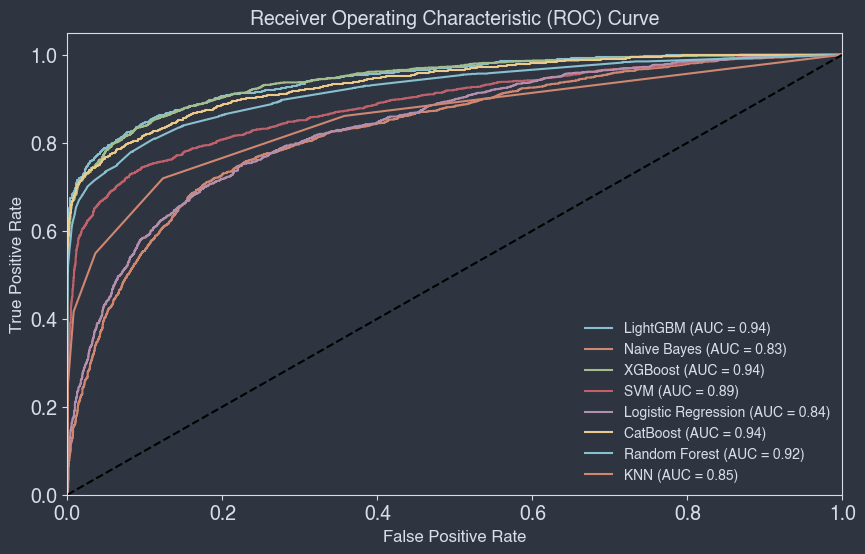

In [73]:
def plot_roc_curves(models, model_names, X_test, y_test):
    plt.figure()
    
    for model, name in zip(models, model_names):
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test)[:, 1]
        else:
            y_prob = model.decision_function(X_test)

        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label='{} (AUC = {:.2f})'.format(name, roc_auc))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()


model_names = list(trained_models.keys())
models = list(trained_models.values())

plot_roc_curves(models, model_names, X_test, y_test)


#### AUC ROC Curves Interpretation

Let's take a look at how well our models did by checking out the AUC ROC curves. These curves help us understand how good our models are at distinguishing between the positive class (loan default) and the negative class (no loan default).

##### What the AUC ROC Curves Tell Us:

- **LightGBM, XGBoost, and CatBoost**: These three models are the rockstars here, each scoring an AUC of 0.94. This means they are excellent at telling apart defaults from non-defaults.
- **Random Forest**: Not far behind with an AUC of 0.92. It's doing a great job too!
- **SVM**: Comes in with an AUC of 0.89. Pretty solid performance.
- **KNN**: Has an AUC of 0.85. It’s doing well, but there's a bit more room for improvement.
- **Logistic Regression**: With an AUC of 0.84, it’s holding its own quite well.
- **Naive Bayes**: Trails with an AUC of 0.83, still decent but not the top performer.

##### What’s AUC ROC?

AUC stands for "Area Under the Curve." It tells us how well the model can distinguish between classes. A perfect model gets an AUC of 1, while a random guess would score 0.5. So, higher is better!

##### Why Does This Matter?

A higher AUC means the model is better at predicting defaults accurately. LightGBM, XGBoost, and CatBoost are doing an awesome job here, making them great choices for our task.

In summary, our top three models are LightGBM, XGBoost, and CatBoost, with Random Forest not far behind. These models are the best at predicting who might default on their loans, which is exactly what we need!

Great job, models!


## Conclusion

Wow, what a journey! 🎉 I, Putanyn Manee, have taken a deep dive into the world of credit risk assessment, and it's been quite an adventure. Here’s a quick recap of what I've accomplished:

1. **Explored and Preprocessed the Data**: I started by understanding my data, handling missing values, transforming skewed features, and encoding categorical variables. This gave me a clean and ready-to-use dataset.

2. **Model Training and Evaluation**: I trained several models, including Logistic Regression, KNN, Naive Bayes, SVM, Random Forest, XGBoost, LightGBM, and CatBoost. Each model was fine-tuned using Optuna to find the best hyperparameters.

3. **Hyperparameter Tuning Results**: After tuning, I found the best parameters for each model. Here’s a quick summary:

| Classifier           | Parameters                                                           |
|----------------------|----------------------------------------------------------------------|
| **LightGBM**         | lgb_n_estimators: 268<br>lgb_max_depth: 16<br>lgb_learning_rate: 0.0844 |
| **Naive Bayes**      | No hyperparameters to tune.                                          |
| **XGBoost**          | xgb_n_estimators: 254<br>xgb_max_depth: 6<br>xgb_learning_rate: 0.0955 |
| **SVM**              | svc_C: 86.896                                                        |
| **Logistic Regression** | lr_C: 70.837                                                      |
| **CatBoost**         | cb_n_estimators: 296<br>cb_learning_rate: 0.0599<br>cb_depth: 8      |
| **Random Forest**    | rf_n_estimators: 27<br>rf_max_depth: 28                              |
| **KNN**              | n_neighbors: 5                                                       |

4. **Model Performance**: I evaluated each model’s performance and plotted the ROC curves to visualize their effectiveness. The top performers were LightGBM, XGBoost, and CatBoost, each with an impressive AUC of 0.94.

### Future Work

But wait, there's more! 🚀 For future work, I plan to explore ensemble models. By combining the strengths of multiple models, I can potentially achieve even better performance. Stay tuned for more exciting developments!

Thank you for joining me on this adventure. Keep exploring and happy modeling! 📊✨

— Putanyn Manee
